In [143]:
!nvidia-smi

Sat Sep 25 08:12:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    60W / 149W |   1859MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [144]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip
# !ls

In [145]:
%matplotlib inline

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.ion()

In [147]:
import argparse

parser = argparse.ArgumentParser(description='Basic Pytorch')

args = parser.parse_args(args=[])

## evaluate option
args.evaluate = True

## batch_size
args.batch_size = 16

## log_interval
args.log_interval = 10

## accuracy state
args.acc = 0.0

## cuda flag
args.cuda =  torch.cuda.is_available()
print(args.cuda)

## control random seed [torch, cuda, cuDnn]
torch.manual_seed(1)

if args.cuda:
  torch.cuda.manual_seed(1)
  ## There is a problem that the computation processing speed is reduced
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

True


In [148]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=args.batch_size,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=args.batch_size,
                                             shuffle=True, num_workers=4)

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


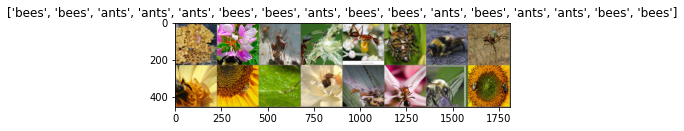

In [149]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [150]:
def save_model(model):
    state = {
        'acc' : args.acc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    file_name = '.'.join(["{:.2f}".format(args.acc), 'pth.tar'])
    
    torch.save(state, file_name)
    print('save model : {}'.format(file_name))

In [151]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, lr : {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data, scheduler.get_last_lr()))
    return

In [152]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).data
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    acc = 100. * float(correct) / len(test_loader.dataset)

    if acc > args.acc and not args.evaluate:
        args.acc = acc
        save_model(model)

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Best Acc : {}\n'.format(
        test_loss * args.batch_size, correct, len(test_loader.dataset),
        100. * float(correct) / len(test_loader.dataset), args.acc))
    return

In [153]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_loader):
        inputs, labels = data
        if args.cuda:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [154]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

if args.cuda:
    model = model.cuda()

# optimizer & criterion
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [155]:
if args.evaluate:
  file_name = '95.42.pth.tar'
  pretrained_model = torch.load(file_name)
  args.acc = pretrained_model['acc']
  model.load_state_dict(pretrained_model['model_state_dict'])
  optimizer.load_state_dict(pretrained_model['optimizer_state_dict'])

In [156]:
## test
if args.evaluate:
  test()

## train
else:
  for epoch in range(1, 80):
    scheduler.step()
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test set: Average loss: 0.1958, Accuracy: 146/153 (95.42%), Best Acc : 95.42483660130719



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


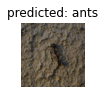

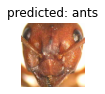

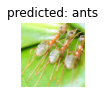

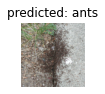

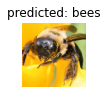

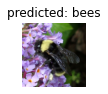

In [157]:
visualize_model(model)